## Wavelet data generation..

In [1]:
def func(cls):
  img_names = os.listdir('genres/'+cls)
  os.makedirs('wavelets/train/'+cls)
  os.makedirs('wavelets/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [2]:
## deepak is commenting this
#import os
#classes = [a for a in os.listdir('genres') if '.' not in a]
#print(classes)

## Spectrogram generation..

In [3]:
import librosa
import matplotlib.pyplot as plt
import librosa.display


def func1(cls):
  img_names = os.listdir('genres/'+cls)
  os.makedirs('spectrogram/train/'+cls)
  os.makedirs('spectrogram/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [4]:
# import os
# classes = [a for a in os.listdir('genres') if '.' not in a]
# print(classes)

## Model training..

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#deepak commented it
# from keras.optimizer_v1 import Adam


from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np
tf.compat.v1.disable_eager_execution()

In [6]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_data('dataset/spectrogram/train')
val = get_data('dataset/spectrogram/test')

C:\Users\user\AppData\Local\Temp\ipykernel_7652\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [11]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

C:\Users\user\miniconda3\envs\digi\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\user\miniconda3\envs\digi\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [12]:
history = model.fit(x_train,y_train,epochs = 100, validation_data = (x_val, y_val))

Train on 600 samples, validate on 400 samples
Epoch 1/100
600/600 [==============================] - ETA: 0s - loss: 2.3287 - accuracy: 0.1300

C:\Users\user\miniconda3\envs\digi\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


600/600 [==============================] - 25s 42ms/sample - loss: 2.3287 - accuracy: 0.1300 - val_loss: 2.2650 - val_accuracy: 0.1300
Epoch 2/100
600/600 [==============================] - 25s 41ms/sample - loss: 2.1969 - accuracy: 0.2033 - val_loss: 2.1787 - val_accuracy: 0.2525
Epoch 3/100
600/600 [==============================] - 23s 39ms/sample - loss: 2.0607 - accuracy: 0.3067 - val_loss: 2.1041 - val_accuracy: 0.3125
Epoch 4/100
600/600 [==============================] - 23s 39ms/sample - loss: 1.9198 - accuracy: 0.3017 - val_loss: 2.0454 - val_accuracy: 0.2475
Epoch 5/100
600/600 [==============================] - 22s 37ms/sample - loss: 1.7935 - accuracy: 0.3383 - val_loss: 1.9665 - val_accuracy: 0.2425
Epoch 6/100
600/600 [==============================] - 22s 36ms/sample - loss: 1.7071 - accuracy: 0.3850 - val_loss: 1.9650 - val_accuracy: 0.2950
Epoch 7/100
600/600 [==============================] - 23s 38ms/sample - loss: 1.6354 - accuracy: 0.3533 - val_loss: 1.9793 - val_

In [ ]:
import pickle
model.save_weights('500_epoch_simple_lr.cpkt')

pickle.dump(history.history, open('history_500_epoch_simple.pkl','wb'))

model performance system



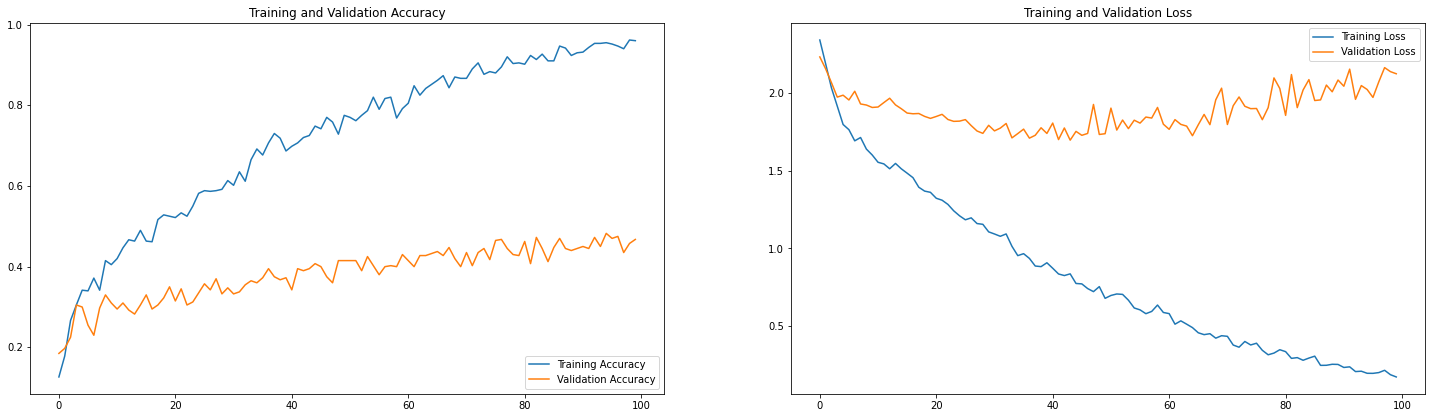

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pickle
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('sim_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1080x432 with 0 Axes>

In [ ]:
predictions = model(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

AttributeError: 
        'Tensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

NameError: name 'predictions' is not defined

# Transfer Learning based modeling

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")

In [ ]:
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(10, activation="softmax")                                     
                                ])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

In [ ]:
model.summary()

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pickle
history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_plot1.png',bbox_inches = 'tight')
plt.clf()

In [ ]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')

In [ ]:
model.save_weights('500_epoch_transfer_lr.cpkt')
pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))


## Multi-Model Training

In [ ]:
sp_train = get_data('dataset/spectrogram/train')
sp_val = get_data('dataset/spectrogram/test')

wv_train = get_data('dataset/wavelets/train')
wv_val = get_data('dataset/wavelets/test')

In [ ]:
x_sp_train = []
y_sp_train = []
x_sp_val = []
y_sp_val = []

for feature, label in sp_train:
  x_sp_train.append(feature)
  y_sp_train.append(label)

for feature, label in sp_val:
  x_sp_val.append(feature)
  y_sp_val.append(label)

# Normalize the data
x_sp_train = np.array(x_sp_train) / 255
x_sp_val = np.array(x_sp_val) / 255

x_sp_train.reshape(-1, img_size, img_size, 1)
y_sp_train = np.array(y_sp_train)

x_sp_val.reshape(-1, img_size, img_size, 1)
y_sp_val = np.array(y_sp_val)

In [ ]:
x_wv_train = []
y_wv_train = []
x_wv_val = []
y_wv_val = []

for feature, label in wv_train:
  x_wv_train.append(feature)
  y_wv_train.append(label)

for feature, label in wv_val:
  x_wv_val.append(feature)
  y_wv_val.append(label)

# Normalize the data
x_wv_train = np.array(x_wv_train) / 255
x_wv_val = np.array(x_wv_val) / 255

x_wv_train.reshape(-1, img_size, img_size, 1)
y_wv_train = np.array(y_wv_train)

x_wv_val.reshape(-1, img_size, img_size, 1)
y_wv_val = np.array(y_wv_val)

In [ ]:
datagen_sp = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_sp.fit(x_sp_train)

datagen_wv = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_wv.fit(x_wv_train)

In [ ]:
input_sp = keras.Input(shape=(256,256,3))
input_wv = keras.Input(shape=(256,256,3))

x = Conv2D(32,3,padding="same", activation="relu")(input_sp)
x = MaxPool2D()(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPool2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(128,activation="relu")(x)
x = keras.Model(inputs=input_sp, outputs=x)

y = Conv2D(32,3,padding="same", activation="relu")(input_wv)
y = MaxPool2D()(y)
y = Conv2D(64, 3, padding="same", activation="relu")(y)
y = MaxPool2D()(y)
y = Dropout(0.4)(y)
y = Flatten()(y)
y = Dense(128,activation="relu")(y)
y = keras.Model(inputs=input_wv, outputs=y)

from tensorflow.keras.layers import concatenate
combined = concatenate([x.output, y.output])

z = Dense(32, activation="relu")(combined)
z = Dense(10, activation="softmax")(z)

model = keras.Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.summary()

In [ ]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
history2 = model.fit([x_sp_train,x_wv_train],y_sp_train,epochs = 100, validation_data = ([x_sp_val,x_wv_val], y_sp_val))

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pickle
history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('multi_plot1.png',bbox_inches = 'tight')
plt.clf()

In [ ]:
predictions = model.predict([x_sp_val,x_wv_val])
print(classification_report(y_wv_val, np.argmax(predictions, axis=1), target_names = labels))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
predictions = np.argmax(predictions, axis=1)
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx3.png',bbox_inches = 'tight')

In [ ]:
epochs_range = range(100)
import matplotlib.pyplot as plt
import pickle 
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc1 = history['accuracy']
val_acc1 = history['val_accuracy']
loss1 = history['loss']
val_loss1 = history['val_loss']

history = pickle.load(open('C:\Users\xaidi\OneDrive\Documents\GitHub\Genre-Classification-using-Deep-learning\history_500_epoch_multi.pkl','rb'))
acc2 = history['accuracy']
val_acc2 = history['val_accuracy']
loss2 = history['loss']
val_loss2 = history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='CNN Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='CNN Validation Accuracy', c='red', linewidth=4)
ax1.plot(epochs_range, acc1, label='Transfer learning Training Accuracy', c = '#e72866', linewidth=4)
ax1.plot(epochs_range, val_acc1, label='Transfer learning Validation Accuracy', c='#282ec7', linewidth=4)
ax1.plot(epochs_range, acc2, label='Multi modal Training Accuracy', c = '#171c1c', linewidth=4)
ax1.plot(epochs_range, val_acc2, label='Multi modal Validation Accuracy', c='#62176e', linewidth=4)

ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='CNN Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='CNN Validation Loss', c='red', linewidth=4)
ax2.plot(epochs_range, loss1, label='Transfer learning Training Loss',c = '#c72866', linewidth=4)
ax2.plot(epochs_range, val_loss1, label='Transfer learning Validation Loss', c='#282ec7', linewidth=4)
ax2.plot(epochs_range, loss2, label='Multi modal Training Loss',c = '#171c1c', linewidth=4)
ax2.plot(epochs_range, val_loss2, label='Multi modal learning Validation Loss', c='#62176e', linewidth=4)

ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('all_1.png',bbox_inches = 'tight')
plt.clf()

2.9.1
